<a href="https://colab.research.google.com/github/Anny-tech/Bayesian_Active_Learning/blob/main/AF_Kernel_comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install/Import Packages

import subprocess
import sys
from typing import Tuple


'''Check which packages are already installed/ need to be installed and install them automatically.'''

def install_package(package: str) -> None:
    """Install a package using pip."""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def check_and_install_packages(required_packages: dict) -> None:
    """Check and install missing packages."""
    for package, import_name in required_packages.items():
        try:
            __import__(import_name)
            print(f"{package} is already installed.")
        except ImportError:
            print(f"{package} is not installed. Installing now...")
            install_package(package)

if __name__ == "__main__":
    required_packages = {
        "torch": "torch",
        "botorch": "botorch",
        "pandas": "pandas",
        "matplotlib": "matplotlib.pyplot",
        "scikit-learn": "sklearn.metrics",
        "numpy": "numpy",
        "gpytorch": "gpytorch"
    }

    check_and_install_packages(required_packages)

# Import required packages
import torch
import pandas as pd
import numpy as np
import gpytorch
from sklearn.preprocessing import MinMaxScaler
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import qExpectedImprovement, qUpperConfidenceBound, \
                              qProbabilityOfImprovement, qSimpleRegret
from botorch.optim import optimize_acqf
from botorch.acquisition.objective import GenericMCObjective
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import os
import imageio
import random

from google.colab import drive
import seaborn as sns


torch is already installed.
botorch is not installed. Installing now...
pandas is already installed.
matplotlib is already installed.
scikit-learn is already installed.
numpy is already installed.
gpytorch is already installed.


In [9]:
# @title Utility Functions

# Set random state
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Load dataset
def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df = df.drop(columns=['Folder Name'])
    return df

# Initialize data in tensor format
def initialize_tensors(df: pd.DataFrame) -> tuple:
    X_np = df[['Temperature_K', 'Strain', 'Shear_Strain']].values
    Y_np = df['Avg_twist_ang'].values
    X_i = torch.tensor(X_np, dtype=torch.float64).to(device)
    Y_org = torch.tensor(Y_np, dtype=torch.float64).unsqueeze(-1).to(device)

    return X_i, Y_org, torch.tensor(X_np, dtype=torch.float64), \
    torch.tensor(Y_np, dtype=torch.float64).unsqueeze(-1)

# Function to generate seed points at the beginning of each BO iteration
def initialize_samples(X_i: torch.Tensor, Y_org: torch.Tensor, num_samples: int) -> tuple:
    indices = torch.randperm(X_i.size(0))[:num_samples]
    X_init = X_i[indices]
    Y_init = Y_org[indices]
    return X_init, Y_init

# Random sampling function
def random_sampler(model: SingleTaskGP, X_i: torch.Tensor, batch_size: int, \
                   **kwargs) -> torch.Tensor:
    indices = torch.randperm(X_i.size(0))[:batch_size]
    return X_i[indices]

#Initialization of GP model
def initialize_model(X: torch.Tensor, Y: torch.Tensor, kernel: gpytorch.kernels.Kernel) -> SingleTaskGP:
    gp_model = SingleTaskGP(X, Y, covar_module=kernel)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_mll(mll)
    return gp_model

#Function for optimization of acquisition function
def optimize_acquisition_function(acq_func, gp_model: SingleTaskGP, Y_sample: torch.Tensor, bounds: torch.Tensor, batch_size: int, target_value: float) -> torch.Tensor:
    acq = acq_func(gp_model, best_f=target_value) if acq_func in [qExpectedImprovement, qProbabilityOfImprovement] else acq_func(gp_model, beta=0.1)
    candidates, _ = optimize_acqf(
        acq_function=acq,
        bounds=bounds,
        q=batch_size,
        num_restarts=5,
        raw_samples=20,
    )
    return candidates

# Function to rank acquisition functions for BO and kernels for GP
def rank_acquisition_kernels(acq_funcs: list, kernels: list, X_i: torch.Tensor,
                             Y_org: torch.Tensor, bounds: torch.Tensor, target_value: float) -> tuple:
    uncertainties = []
    for acq_func in acq_funcs:
        for kernel in kernels:
            gp_model = initialize_model(X_i, Y_org, kernel)
            if acq_func == random_sampler:
                candidates = random_sampler(gp_model, X_i, batch_size=5)
            else:
                acq = acq_func(gp_model, best_f=target_value) if acq_func in [qExpectedImprovement, qProbabilityOfImprovement] else acq_func(gp_model, beta=0.1)
                candidates, _ = optimize_acqf(
                    acq_function=acq,
                    bounds=bounds,
                    q=5,
                    num_restarts=5,
                    raw_samples=20,
                )
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                observed_pred = gp_model.likelihood(gp_model(X_i))
                variance = observed_pred.variance
            uncertainty = torch.mean(variance).item()
            uncertainties.append((acq_func, kernel, uncertainty))
    return min(uncertainties, key=lambda x: x[2])

# Function to discretize the values of sampled unique candidates from each iteration
def find_closest_values(candidates: torch.Tensor, X_org: torch.Tensor) -> torch.Tensor:
    closest_values = []
    for candidate in candidates:
        closest_candidate = []
        for i, value in enumerate(candidate):
            distances = torch.abs(X_org[:, i] - value)
            closest_value = X_org[distances.argmin(), i]
            closest_candidate.append(closest_value)
        closest_values.append(torch.tensor(closest_candidate))
    return torch.stack(closest_values)

# Function to rank the unique candidates based on acquisition function values
def rank_candidates(acq_func, gp_model, candidates, target_value):
    individual_acq_values = []
    for point in candidates:
        if acq_func in [qExpectedImprovement, qProbabilityOfImprovement]:
            acq = acq_func(gp_model, best_f=target_value)
        elif acq_func == qUpperConfidenceBound:
            acq = acq_func(gp_model, beta=0.1)
        else:
            acq = acq_func(gp_model)

        with torch.no_grad():
            acq_value = acq(point.unsqueeze(0))
        individual_acq_values.append(acq_value.item())

    # Ensure ranked_candidates are tensors
    ranked_candidates = torch.stack([x for _, x in sorted(zip(individual_acq_values, candidates), key=lambda pair: pair[0], reverse=True)])
    ranked_values = sorted(individual_acq_values, reverse=True)
    return ranked_candidates, ranked_values

'''Function to save ranked unique candidates from each iteration to .dat files
to be used to spawn MD simulations'''
def save_rank_file(candidates: list, uncertainty: float, acq_func_name: str, iteration: int, ranked_candidates: list, ranked_values: list) -> None:
    rank_file_path = f'rank_{acq_func_name}_iter{iteration}.dat'
    with open(rank_file_path, 'w') as f:
        f.write('Ranked Candidates:\n')
        for candidate, value in zip(candidates, ranked_values):
            f.write(f"Candidate: {candidate}, Value: {value}\n")
        f.write('\nUncertainty:\n')
        f.write(str(uncertainty))


'''Function to extract the Y value prediction from GP model post each BO iteration
from the ranked unique candidates'''
def get_Y_next(candidates: torch.Tensor, gp_model: SingleTaskGP) -> torch.Tensor:
    gp_model.eval()
    with torch.no_grad():
        Y_next = gp_model(candidates).mean
    return Y_next.unsqueeze(-1)  # Ensure Y_next is 2D

#Function to augment original dataset after each BO loop (the point of doing Active Learning)
def update_samples(unique_candidates_tensor: torch.Tensor, X_org: torch.Tensor,
                   Y_true: torch.Tensor, X_sample: torch.Tensor,
                   Y_sample: torch.Tensor, Y_next: torch.Tensor) -> tuple:
    if unique_candidates_tensor.dim() == 1:
        unique_candidates_tensor = unique_candidates_tensor.unsqueeze(0)
    device = unique_candidates_tensor.device #Get the device of candidates
    X_org = torch.cat([X_org, unique_candidates_tensor])
    Y_true = torch.cat([Y_true, Y_next])
    X_sample = torch.cat([X_sample, unique_candidates_tensor])
    Y_sample = torch.cat([Y_sample, Y_next])
    return X_org, Y_true, X_sample, Y_sample

def update_samples_all(candidates: torch.Tensor, X_org: torch.Tensor,
                       Y_true: torch.Tensor, X_sample: torch.Tensor,
                       Y_sample: torch.Tensor, Y_next: torch.Tensor) -> tuple:
    X_org = torch.cat([X_org, candidates])
    Y_true = torch.cat([Y_true, Y_next])
    #X_sample = torch.cat([X_sample, candidates])
    #Y_sample = torch.cat([Y_sample, Y_next])
    return X_org, Y_true

#Function to calculate model uncertainty
def calculate_uncertainty(gp_model: SingleTaskGP, X_sample: torch.Tensor) -> float:
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = gp_model.likelihood(gp_model(X_sample))
        variance = observed_pred.variance
    return torch.mean(variance).item()

# Function calculate model performance -> to pull True Avg. Twist Angle values from MD simulations.
def MD_set_get(gp_model: SingleTaskGP, candidates: torch.Tensor, Y_true: torch.Tensor) -> float:
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Get predictive distribution from the model
        pred_dist = gp_model.likelihood(gp_model(candidates))
        # Extract the mean and variance
        Y_pred = pred_dist.mean
        uncertainty = pred_dist.variance
    # Compute the difference between true values and predicted means
    prediction_error = (Y_pred - Y_true).abs()
    # Calculate weighted uncertainty by comparing prediction error with predicted variance
    weighted_uncertainty = (prediction_error / uncertainty).mean().item()

    return weighted_uncertainty


# Prints iteration information post each BO iteration
def print_iteration_info(iteration: int, candidates: torch.Tensor,
                         Y_next: torch.Tensor, Y_sample: torch.Tensor,
                         Y_true: torch.Tensor, mse: float, uncertainty: float) -> None:
    print(f"Iteration {iteration + 1}: Candidates = {candidates}, \
            Y_next = {Y_next.numpy().flatten()}, MSE = {mse}, \
            Uncertainty = {uncertainty}\n")

# Function to create a final dataframe of final augmented dataset
def create_results_dataframe(X_org: torch.Tensor, Y_true: torch.Tensor,
                             performance: list, uncertainties: list) -> pd.DataFrame:
    uncertainties += [None] * (len(X_org) - len(uncertainties))
    return pd.DataFrame({
        'Temperature_K': X_org[:, 0].numpy(),
        'Strain': X_org[:, 1].numpy(),
        'Shear_Strain': X_org[:, 2].numpy(),
        'Objective_Value': Y_true.flatten().numpy()
    })

#Function to create 3-d sampling evolution plots -> Gives a temporal sense of evolution of BO iterations
def plot_3d_scatter(X_i: torch.Tensor, unique_candidates: list,
                    candidates: torch.Tensor, X_sample: torch.Tensor,
                    title: str, Y_org: torch.Tensor) -> str:
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot original data points
    scatter = ax.scatter(X_i[:,1], X_i[:,2], X_i[:,0], c=Y_org, cmap='viridis',
                         marker='o', s = 50, edgecolor='black', alpha = 0.6,
                         label='Ground truth \n (Avg. Twist Angles)')

    # Plot initial samples
    ax.scatter(X_sample[:, 1], X_sample[:, 2], X_sample[:, 0], c='g', marker='^',
               alpha = 1.0, s=100, label='Seed Points')

    # Plot candidates
    if len(unique_candidates) > 0:
        candidates = np.array(unique_candidates).reshape(-1, 3)
        ax.scatter(candidates[:, 1], candidates[:, 2], candidates[:, 0], c='r',
                   marker='d', alpha =1.0, s=180, label='Candidates')

    ax.set_xlabel('Strain')
    ax.set_ylabel('Shear_Strain')
    ax.set_zlabel('Temperature_K')
    ax.set_title(title)
    ax.legend()

    #Add colorbar
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Average Twist Angle')
    plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right', frameon=False)
    plot_filename = f'{title}.png'
    plt.tight_layout()
    plt.savefig(plot_filename, dpi=300)
    plt.close()
    return plot_filename

def plot_best_values(best_values: list, uncertainties: list, n_iterations: int,
                     acq_func, kernel) -> str:
    plt.figure(figsize=(13.5, 6))

    best_values = np.array(best_values)
    uncertainties = np.array(uncertainties)

    if len(best_values) != len(uncertainties):
        raise ValueError("Length of best_values and uncertainties must match")

    # Plot best values with error bars
    plt.errorbar(range(len(best_values)), best_values, yerr=uncertainties, fmt='ko-',
                 label=f'{acq_func.__name__} with {kernel.__class__.__name__}',
                 capsize=5)

    # Uncertainty evolution region (2*sigma)
    plt.fill_between(range(len(best_values)),
                     best_values - 2 * uncertainties,
                     best_values + 2 * uncertainties,
                     color='blue', alpha=0.2, label='Uncertainty region')

    # Find the best value and its location in the iteration space
    best_value = max(best_values)
    best_index = best_values.tolist().index(best_value)

    # Annotate the best value
    plt.text(best_index, best_value, f' ({best_index}, {best_value:.2f})',
             color='red', fontsize=10, verticalalignment='bottom')

    plt.xlabel('Iteration')
    plt.ylabel('Best Target Value')
    plt.legend()
    plot_filename = f'best_values_{acq_func.__name__}_{kernel.__class__.__name__}.png'
    plt.legend(bbox_to_anchor=(1.8, 1), loc='upper right', frameon=False)
    plt.tight_layout()
    plt.savefig(plot_filename, dpi=300)
    plt.close()
    return plot_filename

# Function to plot best values with uncertainties for all combinations
def plot_best_values_with_uncertainty(data_list):
    plt.figure(figsize=(45, 10))

    # Define unique markers and colors
    markers = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p', 'h', 'H', 'X']
    colors = plt.cm.viridis(np.linspace(0, 1, len(data_list)))
    plt.rcParams.update({'font.size': 20})

    best_values_data = []

    for idx, data in enumerate(data_list):
        best_values = np.array(data['best_values'])
        uncertainties = np.array(data['best_uncertainties'])
        ac_func_kernel = data['ac_func_kernel']

        plt.plot(best_values, label=ac_func_kernel, marker=markers[idx % len(markers)],
                 color=colors[idx], markersize=12, markeredgecolor='k')
        plt.fill_between(range(len(best_values)),
                         best_values - 2 * uncertainties,
                         best_values + 2 * uncertainties,
                         color=colors[idx], alpha=0.2)

        # Find the best value and its location in the iteration space
        best_value = max(best_values)
        best_iteration = best_values.tolist().index(best_value)

        # Add star marker at the best value
        plt.plot(best_iteration, best_value, marker='*', markersize=15, color='red')

        # Store the best value and its iteration
        best_values_data.append({
            'best_Y_value': best_value,
            'iteration': best_iteration,
            'acquisition_function_kernel_name': ac_func_kernel
        })

    plt.xlabel('Iteration')
    plt.ylabel('Best Value')
    plt.title('Best Values with Uncertainty Across Combinations')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('best_values_with_uncertainty.png', dpi=300)
    plt.show()
    plt.close()

    # Convert best values data to DataFrame and print
    best_values_df = pd.DataFrame(best_values_data)
    print(best_values_df)

    return best_values_df


#Function to create .gif from images of BO iterations
def create_gif(plot_filenames: list, gif_filename: str, delay: float = 100.0) -> None:
    with imageio.get_writer(gif_filename, mode='I', duration=delay) as writer:
        for filename in plot_filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            os.remove(filename)


'''Define Bayesian Optimization Function. Performs the following:
Step 1: Considers all combinations of acquisition functions and GP model kernels
to extract best values for all 50 iterations and plot the best value closest to
the desired valued (in this case y_max) and the corresponding iteration for
each combination.
Step 2: Considers only the best acuisition function and kernel combination based
on the model performance using them, ranks batched candidates according to the
acquisition function value extracted for each and plots the evolution of sampling
(original data grid + Seed points for each iteration + unique sampled candidates)
in the BO iterations. '''

#Defines the Bayesian Optimization based Active Learning
def bayesian_optimization(n_iterations: int, X_sample: torch.Tensor,
                          Y_sample: torch.Tensor, X_i: torch.Tensor,
                          Y_org: torch.Tensor, bounds: torch.Tensor,
                          target_value: float) -> pd.DataFrame:
    superlist_data = []
    performance = []
    uncertainties = []
    best_values = []
    best_uncertainties = []
    batch_size = 5
    X_org = X_i.clone().detach()
    Y_true = Y_org.clone().detach()
    previous_candidates = set()
    plot_filenames_all = []
    plot_filenames = []

    #Declare list of acquisition functions and kernels to consider
    acq_funcs = [qExpectedImprovement, qUpperConfidenceBound,
                 qProbabilityOfImprovement, random_sampler]
    kernels = [gpytorch.kernels.RBFKernel(), gpytorch.kernels.MaternKernel(),
               gpytorch.kernels.PeriodicKernel()]

    for acq_func in acq_funcs:
      for kernel in kernels:
        best_values = []
        best_uncertainties = []  # Reset for each combination
        predicted_Y_values = []  # Store predicted Y values for each iteration
        for i in range(n_iterations):
          gp_model = initialize_model(X_sample, Y_sample, kernel)
          if acq_func == random_sampler:
            candidates = random_sampler(gp_model, X_sample, batch_size)
            ranked_candidates = candidates
            ranked_values = [0] * len(candidates)
          else:
            candidates = optimize_acquisition_function(acq_func, gp_model,
                                                       Y_sample, bounds,
                                                       batch_size, target_value)
            ranked_candidates, ranked_values = rank_candidates(acq_func,
                                                               gp_model,
                                                               candidates, target_value)
          # Check if the candidate is already in the previous candidates
          unique_candidates = []
          for candidate in ranked_candidates:
            candidate_tuple = tuple(candidate.cpu().numpy())
            if candidate_tuple not in previous_candidates:
              unique_candidates.append(candidate.cpu().numpy().reshape(1, -1))
              previous_candidates.add(candidate_tuple)

          # Convert unique_candidates to a PyTorch tensor
          if unique_candidates:
            unique_candidates_tensor = torch.tensor(unique_candidates,
                                                    dtype=torch.float64)

          # Dimension > 2 does not work properly during conversion to numpy array
          if unique_candidates_tensor.dim() > 2:
            unique_candidates_tensor = unique_candidates_tensor.squeeze()

          # Ensure unique_candidates_tensor is in the same device as other tensors
          if torch.cuda.is_available():
            unique_candidates_tensor = unique_candidates_tensor.to('cuda')
          else:
            print("No unique candidates found. Skipping update for this iteration.")

          #Dimension < 2 does not work properly during conversion to numpy array
          if unique_candidates_tensor.dim() < 2:
            unique_candidates_tensor = unique_candidates_tensor.unsqueeze(0)
          Y_next = get_Y_next(unique_candidates_tensor, gp_model)
          X_org, Y_true, X_sample, Y_sample = update_samples(unique_candidates_tensor,
                                                               X_org, Y_true, X_sample,
                                                               Y_sample, Y_next)
          #performance.append(mean_squared_error(Y_sample.cpu(), Y_true[:len(Y_sample)].cpu()))
          uncertainties.append(calculate_uncertainty(gp_model, X_sample)) #model uncertainties
          # Find the Y_next value closest to the target_value
          closest_value_index = torch.argmin(torch.abs(Y_next - target_value)).item()
          best_values.append(Y_next[closest_value_index].item())

          # Store predicted Y values for this iteration
          predicted_Y_values.append(Y_next.mean().item())

          # Find the index of the Y_next value closest to the target_value
          best_value_index = torch.argmin(torch.abs(Y_next - target_value)).item()
          best_candidate = unique_candidates_tensor[best_value_index].unsqueeze(0)

          # Calculate uncertainty for the best candidate
          best_candidate_pred = gp_model.likelihood(gp_model(best_candidate))
          best_candidate_closest_index = torch.argmin(torch.abs(X_i - best_candidate), dim=0)
          best_candidate_closest_Y_org = Y_org[best_candidate_closest_index]
          best_candidate_uncertainty = ((best_candidate_pred.mean -
                                        best_candidate_closest_Y_org).abs()/best_candidate_pred.variance).mean().item()

          best_uncertainties.append(best_candidate_uncertainty) #uncertainties calculated w.r.t True_Y values

        filename = plot_best_values(best_values, best_uncertainties,
                                            n_iterations, acq_func, kernel)
        plot_filenames_all.append(filename)
        data_dict = {'best_values': best_values,
                    'best_uncertainties': best_uncertainties,
                    'ac_func_kernel': f'{acq_func.__name__} + {kernel.__class__.__name__}'
                }
        superlist_data.append(data_dict)
      p_df = plot_best_values_with_uncertainty(superlist_data)
    create_gif(plot_filenames_all, 'acquisition_function_evolution.gif', delay=1000.0)
    return p_df

In [10]:
# @title BO execution: <br> Import/Load dataset
drive.mount('/content/gdrive')     #change drive according to where you choose to run
file_path = '/content/gdrive/MyDrive/Research/data_twist_angle_1.csv' #change path according to where you choose to run
df = load_data(file_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
df

Temperature_K  Strain  Shear_Strain  Avg_twist_ang
0            1500   1.000         1.000      25.465624
1             500   1.000         1.000      12.641907
2            2500   1.000         1.000       0.188142
3            2500   1.015         1.000       8.608880
4             500   1.015         1.000       8.932990
5             500   1.035         1.000       6.923419
6            3500   1.000         1.000      12.233815
7            1500   1.035         1.000      11.091943
8            3500   1.015         1.000       8.035777
9            1500   1.015         1.000      25.829181
10           2500   1.035         1.000       8.435044
11           3500   1.035         1.000       1.639651
12           2500   1.000         1.015       0.188142
13            500   1.000         1.015      12.641907
14           3500   1.055         1.000       3.536723
15            500   1.055         1.000       2.970207
16           1500   1.000         1.015      25.465624
17           2500   1.055         1.000      18.793774
18           1500   1.055         1.000      13.791097
19           3500   1.000         1.015      12.233815
20            500   1.015         1.015       8.932990
21           1500   1.015         1.015      25.829181
22           2500   1.015         1.015       8.608880
23           3500   1.015         1.015       8.035777
24           3500   1.055         1.015       3.536723
25            500   1.000         1.035      12.641907
26           3500   1.035         1.015       1.639651
27           2500   1.055         1.015      18.793774
28           1500   1.035         1.015      11.079225
29            500   1.055         1.015       2.970207
30            500   1.035         1.015       6.922903
31           1500   1.055         1.015      13.791097
32           2500   1.035         1.015       8.435044
33            500   1.035         1.035       6.923419
34           1500   1.000         1.035      25.465624
35           3500   1.000         1.035       0.000000
36           1500   1.035         1.035      11.091943
37           2500   1.015         1.035       8.608880
38           3500   1.015         1.035       8.035777
39            500   1.015         1.035       8.932990
40           1500   1.015         1.035      25.829181
41           2500   1.000         1.035       0.188142
42           2500   1.035         1.035       8.435044

<Axes: xlabel='Avg_twist_ang', ylabel='Count'>

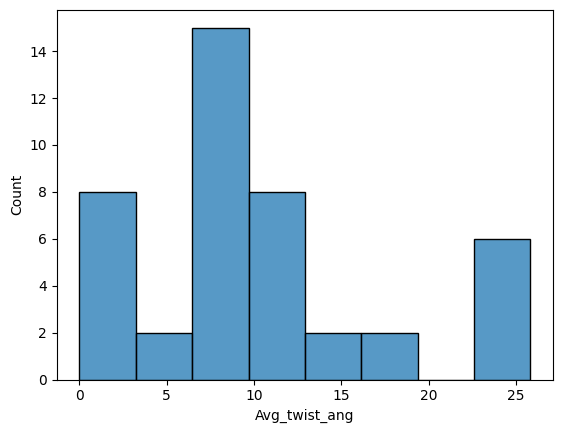

In [12]:
# @title Explore target value ('Avg_twist_ang') distribution

sns.histplot(data=df, x=df.Avg_twist_ang)


In [13]:
# @title Set up device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [14]:
# @title Data Pre-Processing
X_i, Y_org, X_org, Y_true = initialize_tensors(df)
X_i = X_i.to(device)
Y_org = Y_org.to(device)
X_org = X_org.to(device)
Y_true = Y_true.to(device)
bounds = torch.tensor([[500, 1.0, 1.0], [3500, 1.05, 1.05]],
                      dtype=torch.float64).to(device)
X_init, Y_init = initialize_samples(X_i, Y_org, num_samples=20)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([8.1169], dtype=torch.float64), mean = tensor([11.2345], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.
No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.
No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([5.3357], dtype=torch.float64), mean = tensor([11.2935], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.6078], dtype=torch.float64), mean = tensor([11.2980], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.
No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([4.1144], dtype=torch.float64), mean = tensor([11.3012], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.
No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.
No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.3901], dtype=torch.float64), mean = tensor([11.3063], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.
No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.1784], dtype=torch.float64), mean = tensor([11.3078], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, 

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([3.0020], dtype=torch.float64), mean = tensor([11.3091], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1580], dtype=torch.float64), mean = tensor([11.3156], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1382], dtype=torch.float64), mean = tensor([11.3157], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1758], dtype=torch.float64), mean = tensor([11.4614], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1971], dtype=torch.float64), mean = tensor([11.5801], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2642], dtype=torch.float64), mean = tensor([11.8267], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, 

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, 

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, 

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, 

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py

No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, 

No unique candidates found. Skipping update for this iteration.


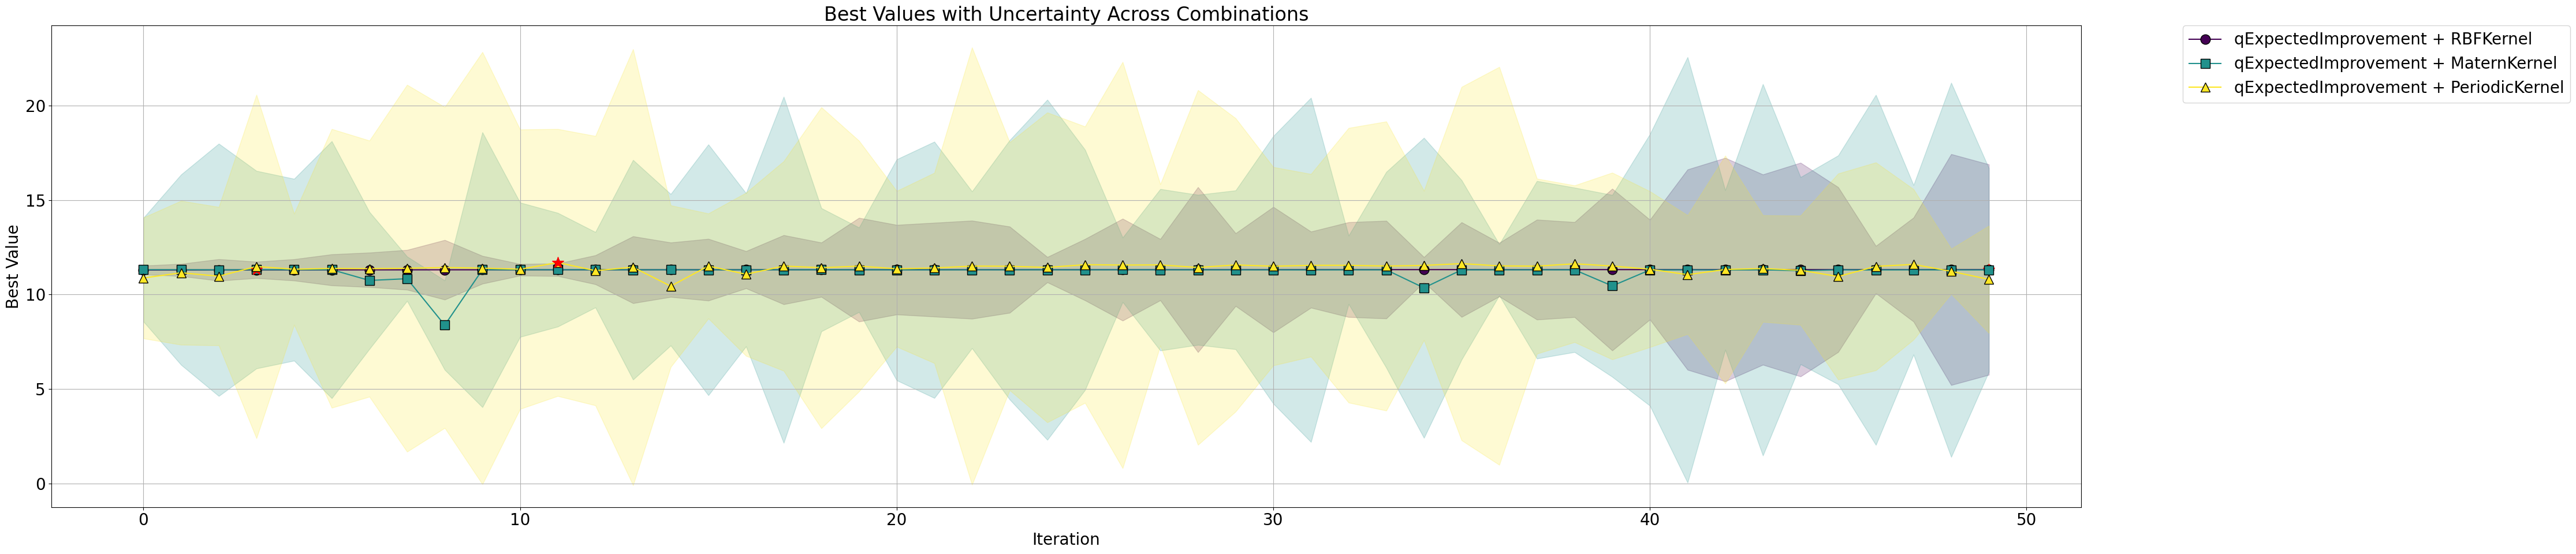

   best_Y_value  iteration       acquisition_function_kernel_name
0     11.324354         49       qExpectedImprovement + RBFKernel
1     11.320042          3    qExpectedImprovement + MaternKernel
2     11.699498         11  qExpectedImprovement + PeriodicKernel


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2345], dtype=torch.float64), mean = tensor([12.0734], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2285], dtype=torch.float64), mean = tensor([12.0742], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2221], dtype=torch.float64), mean = tensor([12.0746], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2161], dtype=torch.float64), mean = tensor([12.0753], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2099], dtype=torch.float64), mean = tensor([12.0754], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.2040], dtype=torch.float64), mean = tensor([12.0758], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1972], dtype=torch.float64), mean = tensor([12.0745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1909], dtype=torch.float64), mean = tensor([12.0741], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1915], dtype=torch.float64), mean = tensor([12.0786], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1857], dtype=torch.float64), mean = tensor([12.0788], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1802], dtype=torch.float64), mean = tensor([12.0795], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1749], dtype=torch.float64), mean = tensor([12.0802], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1694], dtype=torch.float64), mean = tensor([12.0807], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1637], dtype=torch.float64), mean = tensor([12.0822], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1646], dtype=torch.float64), mean = tensor([12.0863], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1593], dtype=torch.float64), mean = tensor([12.0872], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1602], dtype=torch.float64), mean = tensor([12.0913], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1549], dtype=torch.float64), mean = tensor([12.0914], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1496], dtype=torch.float64), mean = tensor([12.0913], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1443], dtype=torch.float64), mean = tensor([12.0927], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1382], dtype=torch.float64), mean = tensor([12.0921], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1334], dtype=torch.float64), mean = tensor([12.0935], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1285], dtype=torch.float64), mean = tensor([12.0941], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1296], dtype=torch.float64), mean = tensor([12.0979], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1247], dtype=torch.float64), mean = tensor([12.0979], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1197], dtype=torch.float64), mean = tensor([12.0980], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1144], dtype=torch.float64), mean = tensor([12.0976], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1087], dtype=torch.float64), mean = tensor([12.0959], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1035], dtype=torch.float64), mean = tensor([12.0961], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0989], dtype=torch.float64), mean = tensor([12.0970], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0941], dtype=torch.float64), mean = tensor([12.0974], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0891], dtype=torch.float64), mean = tensor([12.0972], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0847], dtype=torch.float64), mean = tensor([12.0986], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0801], dtype=torch.float64), mean = tensor([12.0990], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0753], dtype=torch.float64), mean = tensor([12.0985], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0705], dtype=torch.float64), mean = tensor([12.0984], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0662], dtype=torch.float64), mean = tensor([12.0992], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0622], dtype=torch.float64), mean = tensor([12.0991], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0581], dtype=torch.float64), mean = tensor([12.0998], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0538], dtype=torch.float64), mean = tensor([12.1004], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0497], dtype=torch.float64), mean = tensor([12.1008], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0460], dtype=torch.float64), mean = tensor([12.1027], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0417], dtype=torch.float64), mean = tensor([12.1032], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0378], dtype=torch.float64), mean = tensor([12.1038], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0337], dtype=torch.float64), mean = tensor([12.1046], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0297], dtype=torch.float64), mean = tensor([12.1050], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0247], dtype=torch.float64), mean = tensor([12.1034], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0204], dtype=torch.float64), mean = tensor([12.1034], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0162], dtype=torch.float64), mean = tensor([12.1030], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0124], dtype=torch.float64), mean = tensor([12.1034], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0076], dtype=torch.float64), mean = tensor([12.1018], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0028], dtype=torch.float64), mean = tensor([12.1002], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9993], dtype=torch.float64), mean = tensor([12.1006], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9957], dtype=torch.float64), mean = tensor([12.1011], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9923], dtype=torch.float64), mean = tensor([12.1016], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9883], dtype=torch.float64), mean = tensor([12.1018], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9847], dtype=torch.float64), mean = tensor([12.1034], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9807], dtype=torch.float64), mean = tensor([12.1032], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9774], dtype=torch.float64), mean = tensor([12.1040], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9740], dtype=torch.float64), mean = tensor([12.1047], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9759], dtype=torch.float64), mean = tensor([12.1079], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9726], dtype=torch.float64), mean = tensor([12.1091], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9694], dtype=torch.float64), mean = tensor([12.1095], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9660], dtype=torch.float64), mean = tensor([12.1106], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9628], dtype=torch.float64), mean = tensor([12.1109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9595], dtype=torch.float64), mean = tensor([12.1113], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9559], dtype=torch.float64), mean = tensor([12.1116], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9529], dtype=torch.float64), mean = tensor([12.1119], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9497], dtype=torch.float64), mean = tensor([12.1125], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9464], dtype=torch.float64), mean = tensor([12.1131], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9430], dtype=torch.float64), mean = tensor([12.1124], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9450], dtype=torch.float64), mean = tensor([12.1155], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9419], dtype=torch.float64), mean = tensor([12.1159], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9388], dtype=torch.float64), mean = tensor([12.1162], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9346], dtype=torch.float64), mean = tensor([12.1149], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9316], dtype=torch.float64), mean = tensor([12.1152], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9275], dtype=torch.float64), mean = tensor([12.1145], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9246], dtype=torch.float64), mean = tensor([12.1149], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9214], dtype=torch.float64), mean = tensor([12.1151], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9174], dtype=torch.float64), mean = tensor([12.1140], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9142], dtype=torch.float64), mean = tensor([12.1142], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9113], dtype=torch.float64), mean = tensor([12.1149], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9133], dtype=torch.float64), mean = tensor([12.1177], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9104], dtype=torch.float64), mean = tensor([12.1181], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9065], dtype=torch.float64), mean = tensor([12.1172], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9036], dtype=torch.float64), mean = tensor([12.1174], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9006], dtype=torch.float64), mean = tensor([12.1178], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8989], dtype=torch.float64), mean = tensor([12.1212], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8963], dtype=torch.float64), mean = tensor([12.1215], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8984], dtype=torch.float64), mean = tensor([12.1243], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9010], dtype=torch.float64), mean = tensor([12.1286], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8983], dtype=torch.float64), mean = tensor([12.1292], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9004], dtype=torch.float64), mean = tensor([12.1318], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8977], dtype=torch.float64), mean = tensor([12.1326], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8952], dtype=torch.float64), mean = tensor([12.1329], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8972], dtype=torch.float64), mean = tensor([12.1357], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8944], dtype=torch.float64), mean = tensor([12.1356], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8918], dtype=torch.float64), mean = tensor([12.1359], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8938], dtype=torch.float64), mean = tensor([12.1387], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8964], dtype=torch.float64), mean = tensor([12.1432], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8934], dtype=torch.float64), mean = tensor([12.1433], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8906], dtype=torch.float64), mean = tensor([12.1444], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8882], dtype=torch.float64), mean = tensor([12.1431], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8858], dtype=torch.float64), mean = tensor([12.1432], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8830], dtype=torch.float64), mean = tensor([12.1439], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8803], dtype=torch.float64), mean = tensor([12.1431], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8774], dtype=torch.float64), mean = tensor([12.1440], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8750], dtype=torch.float64), mean = tensor([12.1440], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8728], dtype=torch.float64), mean = tensor([12.1439], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8701], dtype=torch.float64), mean = tensor([12.1435], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8674], dtype=torch.float64), mean = tensor([12.1446], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8645], dtype=torch.float64), mean = tensor([12.1453], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8623], dtype=torch.float64), mean = tensor([12.1441], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8597], dtype=torch.float64), mean = tensor([12.1441], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8570], dtype=torch.float64), mean = tensor([12.1439], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8544], dtype=torch.float64), mean = tensor([12.1435], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8520], dtype=torch.float64), mean = tensor([12.1427], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8494], dtype=torch.float64), mean = tensor([12.1425], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8468], dtype=torch.float64), mean = tensor([12.1437], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8446], dtype=torch.float64), mean = tensor([12.1444], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8423], dtype=torch.float64), mean = tensor([12.1435], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8402], dtype=torch.float64), mean = tensor([12.1441], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8379], dtype=torch.float64), mean = tensor([12.1432], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8355], dtype=torch.float64), mean = tensor([12.1427], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8331], dtype=torch.float64), mean = tensor([12.1425], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8310], dtype=torch.float64), mean = tensor([12.1426], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8287], dtype=torch.float64), mean = tensor([12.1422], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8264], dtype=torch.float64), mean = tensor([12.1421], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8241], dtype=torch.float64), mean = tensor([12.1417], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8221], dtype=torch.float64), mean = tensor([12.1423], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8203], dtype=torch.float64), mean = tensor([12.1425], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8181], dtype=torch.float64), mean = tensor([12.1415], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8157], dtype=torch.float64), mean = tensor([12.1416], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8135], dtype=torch.float64), mean = tensor([12.1413], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8113], dtype=torch.float64), mean = tensor([12.1412], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8093], dtype=torch.float64), mean = tensor([12.1413], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8069], dtype=torch.float64), mean = tensor([12.1413], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8047], dtype=torch.float64), mean = tensor([12.1433], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8026], dtype=torch.float64), mean = tensor([12.1423], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8005], dtype=torch.float64), mean = tensor([12.1418], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7985], dtype=torch.float64), mean = tensor([12.1430], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7962], dtype=torch.float64), mean = tensor([12.1428], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7938], dtype=torch.float64), mean = tensor([12.1434], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7919], dtype=torch.float64), mean = tensor([12.1432], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7898], dtype=torch.float64), mean = tensor([12.1429], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7875], dtype=torch.float64), mean = tensor([12.1445], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7852], dtype=torch.float64), mean = tensor([12.1445], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7834], dtype=torch.float64), mean = tensor([12.1435], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7805], dtype=torch.float64), mean = tensor([12.1445], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7786], dtype=torch.float64), mean = tensor([12.1436], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


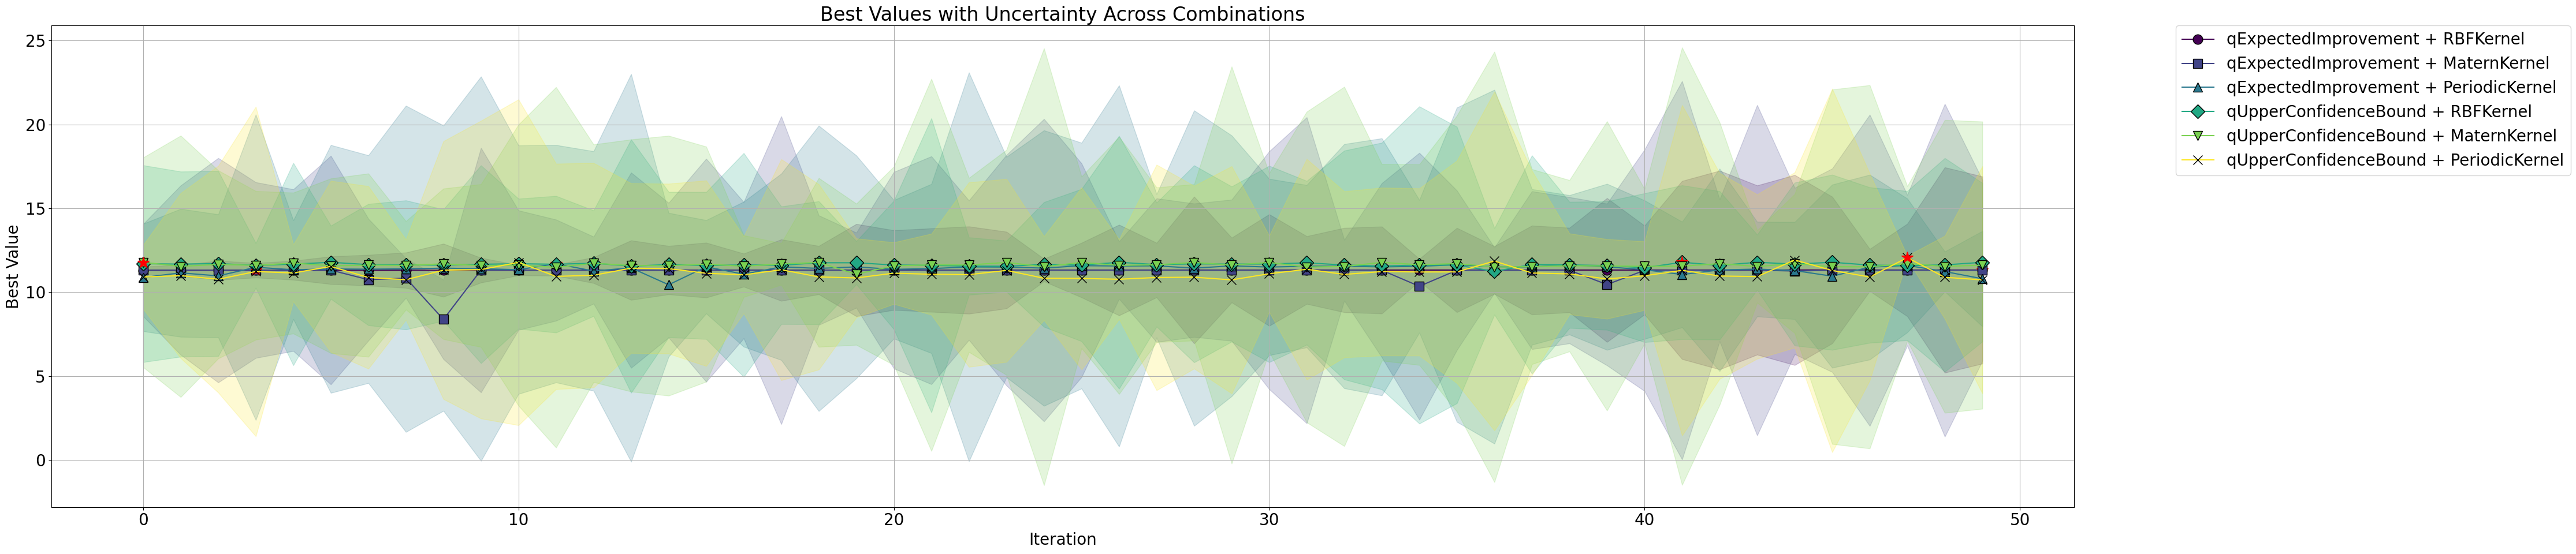

   best_Y_value  iteration        acquisition_function_kernel_name
0     11.324354         49        qExpectedImprovement + RBFKernel
1     11.320042          3     qExpectedImprovement + MaternKernel
2     11.699498         11   qExpectedImprovement + PeriodicKernel
3     11.785918         41       qUpperConfidenceBound + RBFKernel
4     11.780706          0    qUpperConfidenceBound + MaternKernel
5     12.063995         47  qUpperConfidenceBound + PeriodicKernel


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7766], dtype=torch.float64), mean = tensor([12.1434], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7739], dtype=torch.float64), mean = tensor([12.1425], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7712], dtype=torch.float64), mean = tensor([12.1409], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7685], dtype=torch.float64), mean = tensor([12.1395], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7657], dtype=torch.float64), mean = tensor([12.1384], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7631], dtype=torch.float64), mean = tensor([12.1369], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7604], dtype=torch.float64), mean = tensor([12.1354], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7577], dtype=torch.float64), mean = tensor([12.1344], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7556], dtype=torch.float64), mean = tensor([12.1346], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7529], dtype=torch.float64), mean = tensor([12.1335], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7501], dtype=torch.float64), mean = tensor([12.1330], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7475], dtype=torch.float64), mean = tensor([12.1321], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7448], dtype=torch.float64), mean = tensor([12.1309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7423], dtype=torch.float64), mean = tensor([12.1295], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7398], dtype=torch.float64), mean = tensor([12.1279], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7372], dtype=torch.float64), mean = tensor([12.1270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7346], dtype=torch.float64), mean = tensor([12.1256], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7321], dtype=torch.float64), mean = tensor([12.1242], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7296], dtype=torch.float64), mean = tensor([12.1229], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7271], dtype=torch.float64), mean = tensor([12.1215], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7247], dtype=torch.float64), mean = tensor([12.1205], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7221], dtype=torch.float64), mean = tensor([12.1200], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7197], dtype=torch.float64), mean = tensor([12.1187], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7172], dtype=torch.float64), mean = tensor([12.1173], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7147], dtype=torch.float64), mean = tensor([12.1168], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7123], dtype=torch.float64), mean = tensor([12.1151], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7102], dtype=torch.float64), mean = tensor([12.1161], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7078], dtype=torch.float64), mean = tensor([12.1148], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7055], dtype=torch.float64), mean = tensor([12.1134], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7031], dtype=torch.float64), mean = tensor([12.1122], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7006], dtype=torch.float64), mean = tensor([12.1114], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6982], dtype=torch.float64), mean = tensor([12.1103], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6958], dtype=torch.float64), mean = tensor([12.1101], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6934], dtype=torch.float64), mean = tensor([12.1093], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6910], dtype=torch.float64), mean = tensor([12.1083], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6887], dtype=torch.float64), mean = tensor([12.1074], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6869], dtype=torch.float64), mean = tensor([12.1074], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6845], dtype=torch.float64), mean = tensor([12.1071], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6822], dtype=torch.float64), mean = tensor([12.1064], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6800], dtype=torch.float64), mean = tensor([12.1048], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6778], dtype=torch.float64), mean = tensor([12.1033], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6758], dtype=torch.float64), mean = tensor([12.1034], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6735], dtype=torch.float64), mean = tensor([12.1024], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6712], dtype=torch.float64), mean = tensor([12.1011], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6690], dtype=torch.float64), mean = tensor([12.1001], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6668], dtype=torch.float64), mean = tensor([12.0992], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6645], dtype=torch.float64), mean = tensor([12.0981], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6624], dtype=torch.float64), mean = tensor([12.0975], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6601], dtype=torch.float64), mean = tensor([12.0965], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6579], dtype=torch.float64), mean = tensor([12.0959], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6557], dtype=torch.float64), mean = tensor([12.0950], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6538], dtype=torch.float64), mean = tensor([12.0954], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6517], dtype=torch.float64), mean = tensor([12.0941], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6495], dtype=torch.float64), mean = tensor([12.0933], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6473], dtype=torch.float64), mean = tensor([12.0923], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6453], dtype=torch.float64), mean = tensor([12.0908], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6433], dtype=torch.float64), mean = tensor([12.0905], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6418], dtype=torch.float64), mean = tensor([12.0910], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6397], dtype=torch.float64), mean = tensor([12.0901], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6375], dtype=torch.float64), mean = tensor([12.0894], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6359], dtype=torch.float64), mean = tensor([12.0904], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6337], dtype=torch.float64), mean = tensor([12.0897], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6316], dtype=torch.float64), mean = tensor([12.0888], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6295], dtype=torch.float64), mean = tensor([12.0884], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6274], dtype=torch.float64), mean = tensor([12.0874], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6284], dtype=torch.float64), mean = tensor([12.0887], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6263], dtype=torch.float64), mean = tensor([12.0876], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6245], dtype=torch.float64), mean = tensor([12.0874], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6225], dtype=torch.float64), mean = tensor([12.0869], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6205], dtype=torch.float64), mean = tensor([12.0866], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6191], dtype=torch.float64), mean = tensor([12.0870], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6174], dtype=torch.float64), mean = tensor([12.0868], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6153], dtype=torch.float64), mean = tensor([12.0862], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6133], dtype=torch.float64), mean = tensor([12.0854], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6115], dtype=torch.float64), mean = tensor([12.0849], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6095], dtype=torch.float64), mean = tensor([12.0841], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6078], dtype=torch.float64), mean = tensor([12.0838], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6058], dtype=torch.float64), mean = tensor([12.0830], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6038], dtype=torch.float64), mean = tensor([12.0825], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6023], dtype=torch.float64), mean = tensor([12.0825], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6006], dtype=torch.float64), mean = tensor([12.0826], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5986], dtype=torch.float64), mean = tensor([12.0818], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5967], dtype=torch.float64), mean = tensor([12.0808], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5947], dtype=torch.float64), mean = tensor([12.0799], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5928], dtype=torch.float64), mean = tensor([12.0788], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5909], dtype=torch.float64), mean = tensor([12.0781], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5891], dtype=torch.float64), mean = tensor([12.0771], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5874], dtype=torch.float64), mean = tensor([12.0757], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5855], dtype=torch.float64), mean = tensor([12.0747], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5836], dtype=torch.float64), mean = tensor([12.0740], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5828], dtype=torch.float64), mean = tensor([12.0755], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5809], dtype=torch.float64), mean = tensor([12.0746], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5791], dtype=torch.float64), mean = tensor([12.0741], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5772], dtype=torch.float64), mean = tensor([12.0733], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5754], dtype=torch.float64), mean = tensor([12.0726], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5734], dtype=torch.float64), mean = tensor([12.0722], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5716], dtype=torch.float64), mean = tensor([12.0713], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5698], dtype=torch.float64), mean = tensor([12.0703], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5680], dtype=torch.float64), mean = tensor([12.0696], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5662], dtype=torch.float64), mean = tensor([12.0685], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5643], dtype=torch.float64), mean = tensor([12.0679], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5626], dtype=torch.float64), mean = tensor([12.0673], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5609], dtype=torch.float64), mean = tensor([12.0663], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5592], dtype=torch.float64), mean = tensor([12.0656], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5574], dtype=torch.float64), mean = tensor([12.0651], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5557], dtype=torch.float64), mean = tensor([12.0643], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5539], dtype=torch.float64), mean = tensor([12.0641], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5523], dtype=torch.float64), mean = tensor([12.0629], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5507], dtype=torch.float64), mean = tensor([12.0619], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5492], dtype=torch.float64), mean = tensor([12.0606], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5476], dtype=torch.float64), mean = tensor([12.0595], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5462], dtype=torch.float64), mean = tensor([12.0594], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5448], dtype=torch.float64), mean = tensor([12.0585], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5433], dtype=torch.float64), mean = tensor([12.0585], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5417], dtype=torch.float64), mean = tensor([12.0575], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5407], dtype=torch.float64), mean = tensor([12.0564], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5390], dtype=torch.float64), mean = tensor([12.0560], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5376], dtype=torch.float64), mean = tensor([12.0551], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5360], dtype=torch.float64), mean = tensor([12.0550], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5344], dtype=torch.float64), mean = tensor([12.0540], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5327], dtype=torch.float64), mean = tensor([12.0533], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5313], dtype=torch.float64), mean = tensor([12.0531], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5298], dtype=torch.float64), mean = tensor([12.0526], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5282], dtype=torch.float64), mean = tensor([12.0515], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5265], dtype=torch.float64), mean = tensor([12.0517], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5252], dtype=torch.float64), mean = tensor([12.0498], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5239], dtype=torch.float64), mean = tensor([12.0482], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5225], dtype=torch.float64), mean = tensor([12.0474], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5212], dtype=torch.float64), mean = tensor([12.0457], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5198], dtype=torch.float64), mean = tensor([12.0442], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5185], dtype=torch.float64), mean = tensor([12.0443], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5169], dtype=torch.float64), mean = tensor([12.0442], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5155], dtype=torch.float64), mean = tensor([12.0432], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5138], dtype=torch.float64), mean = tensor([12.0427], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5126], dtype=torch.float64), mean = tensor([12.0418], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5111], dtype=torch.float64), mean = tensor([12.0418], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5096], dtype=torch.float64), mean = tensor([12.0421], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5083], dtype=torch.float64), mean = tensor([12.0423], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5067], dtype=torch.float64), mean = tensor([12.0419], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5052], dtype=torch.float64), mean = tensor([12.0413], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5038], dtype=torch.float64), mean = tensor([12.0408], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5024], dtype=torch.float64), mean = tensor([12.0398], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5010], dtype=torch.float64), mean = tensor([12.0387], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4997], dtype=torch.float64), mean = tensor([12.0374], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4983], dtype=torch.float64), mean = tensor([12.0374], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4970], dtype=torch.float64), mean = tensor([12.0379], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4956], dtype=torch.float64), mean = tensor([12.0383], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4941], dtype=torch.float64), mean = tensor([12.0375], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4928], dtype=torch.float64), mean = tensor([12.0388], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4913], dtype=torch.float64), mean = tensor([12.0389], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


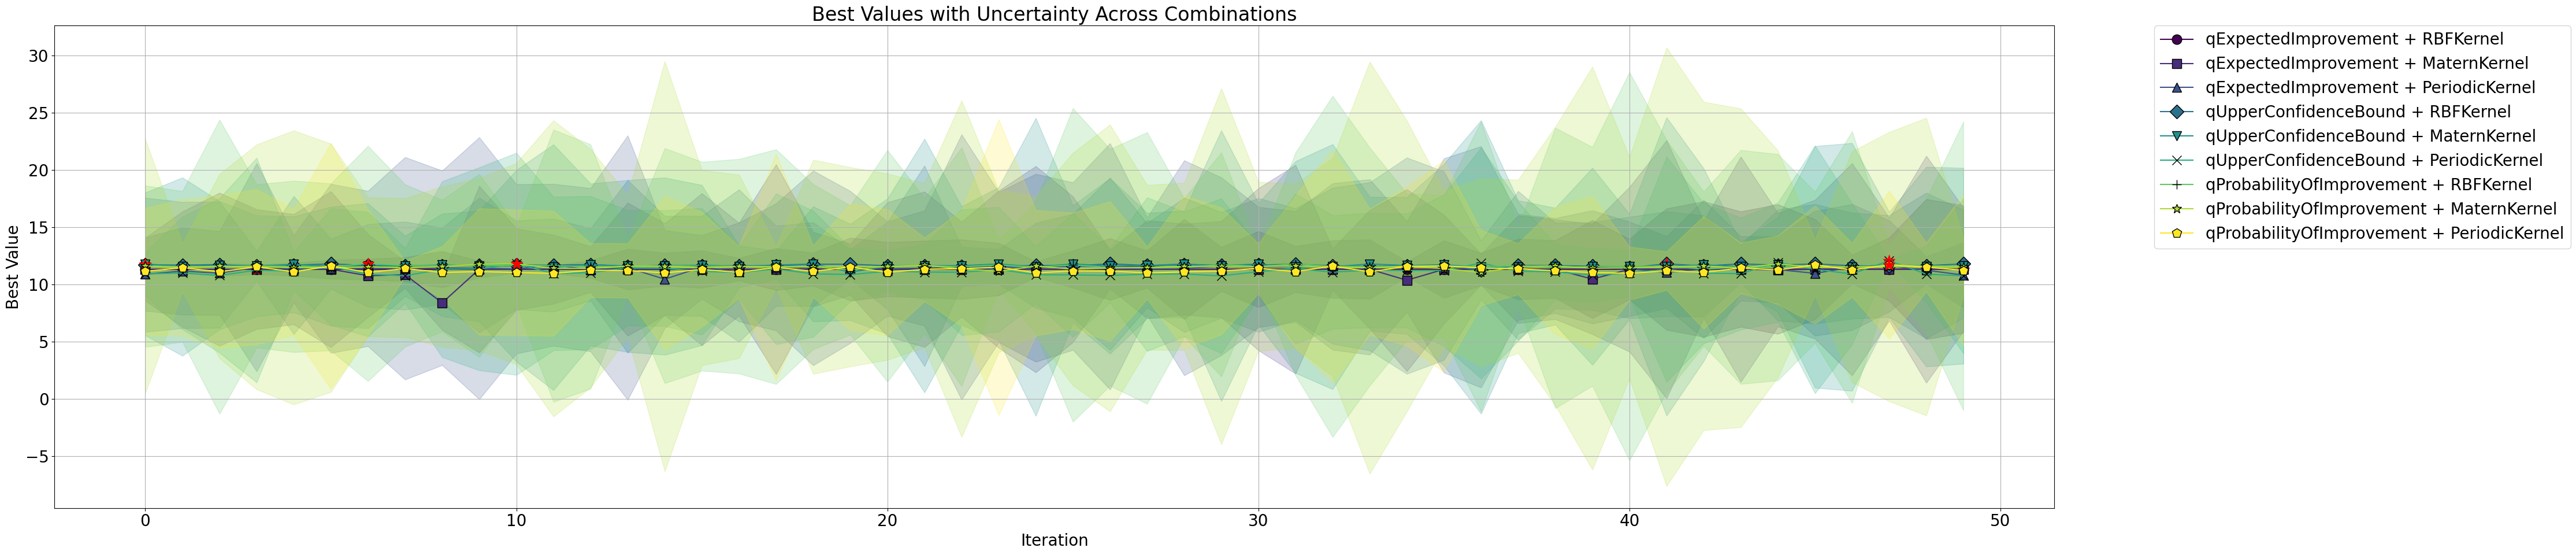

   best_Y_value  iteration            acquisition_function_kernel_name
0     11.324354         49            qExpectedImprovement + RBFKernel
1     11.320042          3         qExpectedImprovement + MaternKernel
2     11.699498         11       qExpectedImprovement + PeriodicKernel
3     11.785918         41           qUpperConfidenceBound + RBFKernel
4     11.780706          0        qUpperConfidenceBound + MaternKernel
5     12.063995         47      qUpperConfidenceBound + PeriodicKernel
6     11.817687          6       qProbabilityOfImprovement + RBFKernel
7     11.798383         10    qProbabilityOfImprovement + MaternKernel
8     11.712295         47  qProbabilityOfImprovement + PeriodicKernel


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4900], dtype=torch.float64), mean = tensor([12.0382], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4884], dtype=torch.float64), mean = tensor([12.0380], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4868], dtype=torch.float64), mean = tensor([12.0377], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4853], dtype=torch.float64), mean = tensor([12.0374], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4837], dtype=torch.float64), mean = tensor([12.0371], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4822], dtype=torch.float64), mean = tensor([12.0369], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4806], dtype=torch.float64), mean = tensor([12.0366], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4791], dtype=torch.float64), mean = tensor([12.0363], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4775], dtype=torch.float64), mean = tensor([12.0360], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4760], dtype=torch.float64), mean = tensor([12.0358], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4745], dtype=torch.float64), mean = tensor([12.0355], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4729], dtype=torch.float64), mean = tensor([12.0352], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4714], dtype=torch.float64), mean = tensor([12.0350], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4699], dtype=torch.float64), mean = tensor([12.0347], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4684], dtype=torch.float64), mean = tensor([12.0344], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4669], dtype=torch.float64), mean = tensor([12.0342], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4654], dtype=torch.float64), mean = tensor([12.0339], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4639], dtype=torch.float64), mean = tensor([12.0337], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4624], dtype=torch.float64), mean = tensor([12.0334], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4609], dtype=torch.float64), mean = tensor([12.0332], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4594], dtype=torch.float64), mean = tensor([12.0329], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4579], dtype=torch.float64), mean = tensor([12.0326], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4565], dtype=torch.float64), mean = tensor([12.0324], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4550], dtype=torch.float64), mean = tensor([12.0321], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4535], dtype=torch.float64), mean = tensor([12.0319], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4521], dtype=torch.float64), mean = tensor([12.0316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4506], dtype=torch.float64), mean = tensor([12.0314], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4492], dtype=torch.float64), mean = tensor([12.0312], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4477], dtype=torch.float64), mean = tensor([12.0309], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4463], dtype=torch.float64), mean = tensor([12.0307], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4449], dtype=torch.float64), mean = tensor([12.0304], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4434], dtype=torch.float64), mean = tensor([12.0302], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4420], dtype=torch.float64), mean = tensor([12.0299], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4406], dtype=torch.float64), mean = tensor([12.0297], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4392], dtype=torch.float64), mean = tensor([12.0295], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4377], dtype=torch.float64), mean = tensor([12.0292], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4363], dtype=torch.float64), mean = tensor([12.0290], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4349], dtype=torch.float64), mean = tensor([12.0288], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4335], dtype=torch.float64), mean = tensor([12.0285], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4321], dtype=torch.float64), mean = tensor([12.0283], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4307], dtype=torch.float64), mean = tensor([12.0281], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4294], dtype=torch.float64), mean = tensor([12.0278], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4280], dtype=torch.float64), mean = tensor([12.0276], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4266], dtype=torch.float64), mean = tensor([12.0274], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4252], dtype=torch.float64), mean = tensor([12.0271], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4238], dtype=torch.float64), mean = tensor([12.0269], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4225], dtype=torch.float64), mean = tensor([12.0267], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4211], dtype=torch.float64), mean = tensor([12.0265], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4198], dtype=torch.float64), mean = tensor([12.0262], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4184], dtype=torch.float64), mean = tensor([12.0260], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4171], dtype=torch.float64), mean = tensor([12.0258], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4157], dtype=torch.float64), mean = tensor([12.0256], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4144], dtype=torch.float64), mean = tensor([12.0254], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4130], dtype=torch.float64), mean = tensor([12.0251], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4117], dtype=torch.float64), mean = tensor([12.0249], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4104], dtype=torch.float64), mean = tensor([12.0247], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4090], dtype=torch.float64), mean = tensor([12.0245], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4077], dtype=torch.float64), mean = tensor([12.0243], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4064], dtype=torch.float64), mean = tensor([12.0241], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4051], dtype=torch.float64), mean = tensor([12.0238], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4038], dtype=torch.float64), mean = tensor([12.0236], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4025], dtype=torch.float64), mean = tensor([12.0234], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4011], dtype=torch.float64), mean = tensor([12.0232], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4046], dtype=torch.float64), mean = tensor([12.0252], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4081], dtype=torch.float64), mean = tensor([12.0272], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4116], dtype=torch.float64), mean = tensor([12.0293], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4150], dtype=torch.float64), mean = tensor([12.0313], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4184], dtype=torch.float64), mean = tensor([12.0333], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4219], dtype=torch.float64), mean = tensor([12.0353], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4253], dtype=torch.float64), mean = tensor([12.0373], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4258], dtype=torch.float64), mean = tensor([12.0364], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4264], dtype=torch.float64), mean = tensor([12.0354], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4269], dtype=torch.float64), mean = tensor([12.0344], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4275], dtype=torch.float64), mean = tensor([12.0335], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4280], dtype=torch.float64), mean = tensor([12.0325], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4286], dtype=torch.float64), mean = tensor([12.0316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4291], dtype=torch.float64), mean = tensor([12.0306], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4297], dtype=torch.float64), mean = tensor([12.0297], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4302], dtype=torch.float64), mean = tensor([12.0287], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4308], dtype=torch.float64), mean = tensor([12.0278], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4313], dtype=torch.float64), mean = tensor([12.0268], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4319], dtype=torch.float64), mean = tensor([12.0259], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4324], dtype=torch.float64), mean = tensor([12.0249], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4330], dtype=torch.float64), mean = tensor([12.0240], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4335], dtype=torch.float64), mean = tensor([12.0230], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4340], dtype=torch.float64), mean = tensor([12.0221], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4346], dtype=torch.float64), mean = tensor([12.0211], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4351], dtype=torch.float64), mean = tensor([12.0202], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4357], dtype=torch.float64), mean = tensor([12.0192], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4362], dtype=torch.float64), mean = tensor([12.0183], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4367], dtype=torch.float64), mean = tensor([12.0173], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4373], dtype=torch.float64), mean = tensor([12.0164], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4378], dtype=torch.float64), mean = tensor([12.0155], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4383], dtype=torch.float64), mean = tensor([12.0145], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4389], dtype=torch.float64), mean = tensor([12.0136], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4394], dtype=torch.float64), mean = tensor([12.0126], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4399], dtype=torch.float64), mean = tensor([12.0117], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4404], dtype=torch.float64), mean = tensor([12.0107], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4410], dtype=torch.float64), mean = tensor([12.0098], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4415], dtype=torch.float64), mean = tensor([12.0089], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4420], dtype=torch.float64), mean = tensor([12.0079], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4417], dtype=torch.float64), mean = tensor([12.0079], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4415], dtype=torch.float64), mean = tensor([12.0080], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4412], dtype=torch.float64), mean = tensor([12.0080], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4409], dtype=torch.float64), mean = tensor([12.0081], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4406], dtype=torch.float64), mean = tensor([12.0081], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4404], dtype=torch.float64), mean = tensor([12.0081], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4401], dtype=torch.float64), mean = tensor([12.0082], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4398], dtype=torch.float64), mean = tensor([12.0082], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4396], dtype=torch.float64), mean = tensor([12.0082], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4395], dtype=torch.float64), mean = tensor([12.0088], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4395], dtype=torch.float64), mean = tensor([12.0093], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4395], dtype=torch.float64), mean = tensor([12.0099], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4395], dtype=torch.float64), mean = tensor([12.0104], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4395], dtype=torch.float64), mean = tensor([12.0109], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4395], dtype=torch.float64), mean = tensor([12.0115], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4395], dtype=torch.float64), mean = tensor([12.0120], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4395], dtype=torch.float64), mean = tensor([12.0126], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4395], dtype=torch.float64), mean = tensor([12.0131], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4394], dtype=torch.float64), mean = tensor([12.0135], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4393], dtype=torch.float64), mean = tensor([12.0139], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4392], dtype=torch.float64), mean = tensor([12.0144], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4390], dtype=torch.float64), mean = tensor([12.0148], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4389], dtype=torch.float64), mean = tensor([12.0152], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4387], dtype=torch.float64), mean = tensor([12.0154], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4386], dtype=torch.float64), mean = tensor([12.0158], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4385], dtype=torch.float64), mean = tensor([12.0163], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4384], dtype=torch.float64), mean = tensor([12.0167], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4382], dtype=torch.float64), mean = tensor([12.0170], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4381], dtype=torch.float64), mean = tensor([12.0174], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4379], dtype=torch.float64), mean = tensor([12.0177], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4377], dtype=torch.float64), mean = tensor([12.0181], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4376], dtype=torch.float64), mean = tensor([12.0185], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4376], dtype=torch.float64), mean = tensor([12.0190], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4375], dtype=torch.float64), mean = tensor([12.0194], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4374], dtype=torch.float64), mean = tensor([12.0198], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4373], dtype=torch.float64), mean = tensor([12.0203], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4372], dtype=torch.float64), mean = tensor([12.0208], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4373], dtype=torch.float64), mean = tensor([12.0213], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4372], dtype=torch.float64), mean = tensor([12.0219], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4371], dtype=torch.float64), mean = tensor([12.0223], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4370], dtype=torch.float64), mean = tensor([12.0226], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4369], dtype=torch.float64), mean = tensor([12.0231], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4368], dtype=torch.float64), mean = tensor([12.0236], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4368], dtype=torch.float64), mean = tensor([12.0240], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4368], dtype=torch.float64), mean = tensor([12.0246], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4365], dtype=torch.float64), mean = tensor([12.0248], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4364], dtype=torch.float64), mean = tensor([12.0252], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4363], dtype=torch.float64), mean = tensor([12.0255], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4361], dtype=torch.float64), mean = tensor([12.0259], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No unique candidates found. Skipping update for this iteration.


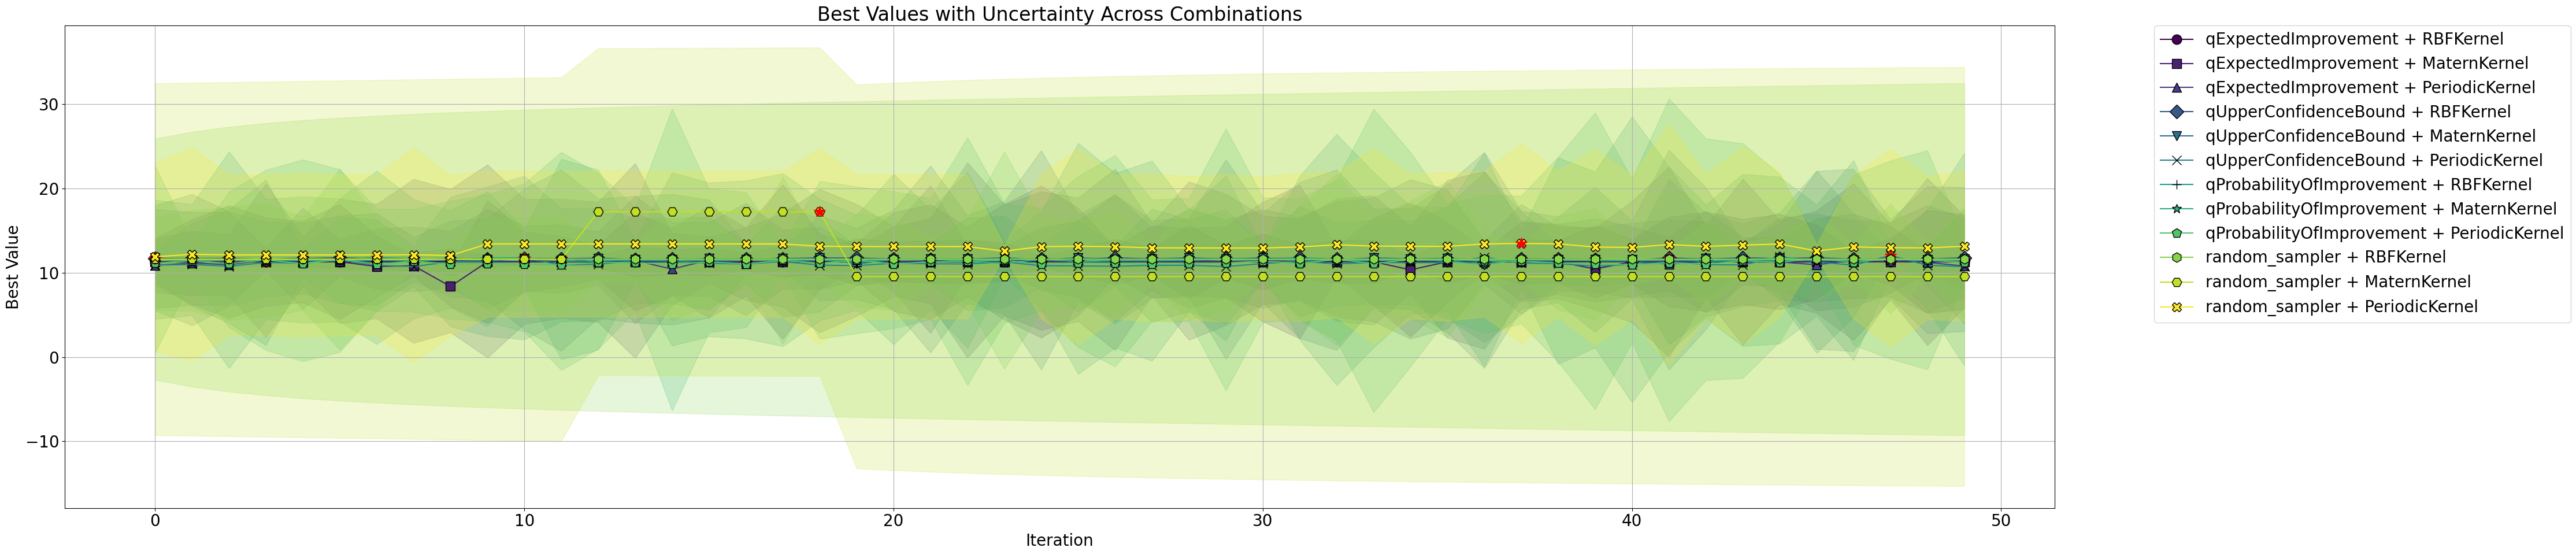

    best_Y_value  iteration            acquisition_function_kernel_name
0      11.324354         49            qExpectedImprovement + RBFKernel
1      11.320042          3         qExpectedImprovement + MaternKernel
2      11.699498         11       qExpectedImprovement + PeriodicKernel
3      11.785918         41           qUpperConfidenceBound + RBFKernel
4      11.780706          0        qUpperConfidenceBound + MaternKernel
5      12.063995         47      qUpperConfidenceBound + PeriodicKernel
6      11.817687          6       qProbabilityOfImprovement + RBFKernel
7      11.798383         10    qProbabilityOfImprovement + MaternKernel
8      11.712295         47  qProbabilityOfImprovement + PeriodicKernel
9      11.610116          0                  random_sampler + RBFKernel
10     17.239928         18               random_sampler + MaternKernel
11     13.481458         37             random_sampler + PeriodicKernel


<ipython-input-9-b8f913c288e4>:337: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Optimization finished.
Best location: [2.500e+03 1.035e+00 1.000e+00]
Best value: [8.43504433]


In [17]:
# @title Run BO_Al
set_random_seed(0)
desired_value = 8.5

# Run Bayesian Optimization with all combinations
p_df = bayesian_optimization(n_iterations=50, X_sample=X_init,
                                             Y_sample=Y_init, X_i=X_i, Y_org=Y_org,
                                             bounds=bounds, target_value=desired_value)

best_idx = torch.argmin(torch.abs(Y_init - torch.tensor(desired_value,
                                                        dtype=torch.float64)))
print("Optimization finished.")
print(f"Best location: {X_init[best_idx].numpy()}")
print(f"Best value: {Y_init[best_idx].numpy()}")